In [2]:
%pylab inline
import pandas as pd
import seaborn as sns

Populating the interactive namespace from numpy and matplotlib


In [3]:
# Load dataset
raw_df = pd.read_csv("/home/brianb/Downloads/odsc_football_modeling_data_2.csv")
df_no_week_1 = raw_df[raw_df.week > 1]

In [4]:
#What columns do we have?
sort(raw_df.columns.values)

array(['away_team', 'fanduel_points', 'full_name', 'home_team',
       'mean_fanduel_points', 'mean_fumbles_lost', 'mean_fumbles_tot',
       'mean_passing_att', 'mean_passing_cmp', 'mean_passing_cmp_air_yds',
       'mean_passing_incmp', 'mean_passing_incmp_air_yds',
       'mean_passing_int', 'mean_passing_sk', 'mean_passing_sk_yds',
       'mean_passing_tds', 'mean_passing_yds', 'mean_receiving_rec',
       'mean_receiving_tar', 'mean_receiving_tds',
       'mean_receiving_yac_yds', 'mean_receiving_yds', 'mean_rushing_att',
       'mean_rushing_loss', 'mean_rushing_loss_yds', 'mean_rushing_tds',
       'mean_rushing_yds', 'opponent', 'player_id', 'position',
       'prev_fanduel_points', 'prev_fumbles_lost', 'prev_fumbles_tot',
       'prev_passing_att', 'prev_passing_cmp', 'prev_passing_cmp_air_yds',
       'prev_passing_incmp', 'prev_passing_incmp_air_yds',
       'prev_passing_int', 'prev_passing_sk', 'prev_passing_sk_yds',
       'prev_passing_tds', 'prev_passing_yds', 'prev_rec

In [5]:
#Let's look at an individual player
raw_df[(raw_df.full_name =='Tom Brady') & (raw_df.week == 2)]

,player_id,full_name,position,team,week,fanduel_points,opponent,home_team,away_team,prev_fanduel_points,...,prev_rushing_att,mean_rushing_att,prev_rushing_loss,mean_rushing_loss,prev_rushing_loss_yds,mean_rushing_loss_yds,prev_rushing_tds,mean_rushing_tds,prev_rushing_yds,mean_rushing_yds
1149,00-0019596,Tom Brady,QB,NE,2,28.24,BUF,BUF,NE,27.62,...,3,3,0,0,0,0,0,0,1,1


In [6]:
#All positions are not created equal
raw_df.groupby('position')['fanduel_points'].sum()

position
C        -10.00
CB         6.30
DB         7.30
DE        -2.00
DT         0.00
FB       377.10
FS         1.00
G          1.50
ILB        0.00
K       3522.12
LB        -2.00
LS         0.00
MLB        0.00
NT         6.10
OG         0.00
OLB        0.00
OT         3.60
P          6.48
QB      7863.20
RB      8882.04
SAF        0.00
SS        -1.80
T          2.00
TE      4709.10
UNK     5815.18
WR     12489.40
Name: fanduel_points, dtype: float64

In [7]:
#Since a few positions seem to score all the points, let's zoom in on those
plot_order = ['TE', 'WR', 'RB', 
              'K', 'QB']
top_positions_only = raw_df[raw_df.position.isin(plot_order)]
top_positions_only.groupby('position')['fanduel_points'].mean()

position
K      7.623636
QB    15.448330
RB     7.244731
TE     4.967405
WR     6.854775
Name: fanduel_points, dtype: float64

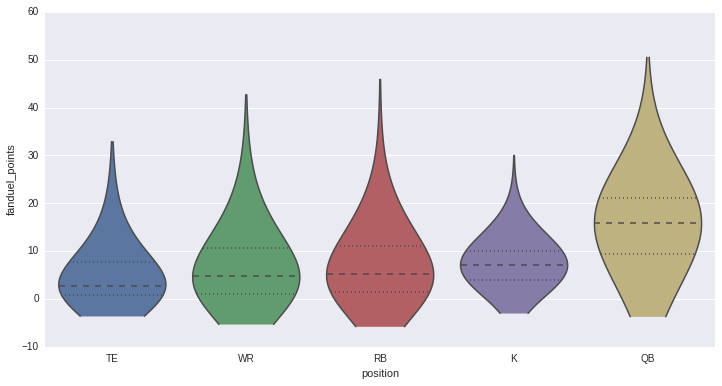

In [8]:
# Violin plots are a nice alternative to boxplots that also show interesting detail about
# the shape of the distribution
nonnull_subset = top_positions_only['fanduel_points'].notnull()
plt.figure(figsize=(12, 6))
sns.violinplot(top_positions_only['fanduel_points'][nonnull_subset], 
               top_positions_only['position'][nonnull_subset], 
               inner='box',
               order=plot_order,
               bw=1)

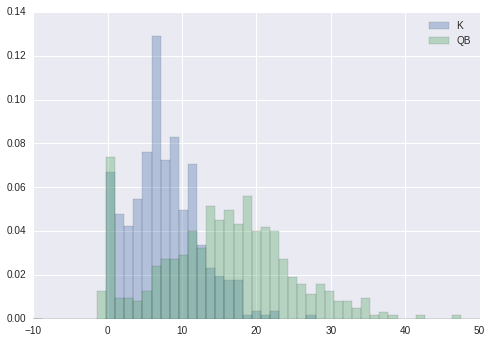

In [9]:
# QB's and kickers score the most points. Let's look into those using a Histogram
qb_k = ['K', 'QB']
qb_k_data = raw_df[raw_df.position.isin(qb_k)]
groups = qb_k_data.groupby('position').groups
for key, row_ids in groups.iteritems():
    pylab.hist(qb_k_data['fanduel_points'][row_ids].values,
               normed=True,
               bins=np.linspace(-10, 50, 50),
               alpha=0.35,
               label=str(key))
pylab.legend()
pylab.figure(figsize=(15,5))

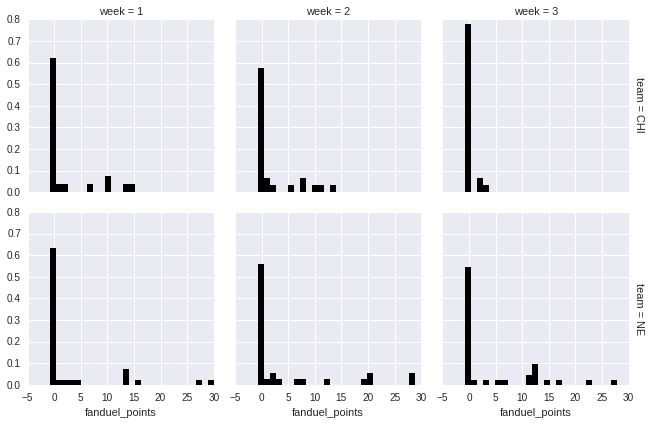

In [10]:
# We can use a Facetgrid to analyze teams
teams = ['NE', 'CHI']
team_data = raw_df[raw_df.team.isin(teams)]
team_data = team_data[team_data.week < 4]
g = sns.FacetGrid(team_data, row="team", col="week", 
                  margin_titles=True, dropna=True)
bins = np.linspace(-3, 30, 30)
g.map(plt.hist, "fanduel_points", color="black", bins=bins, 
      lw=0, normed=True)

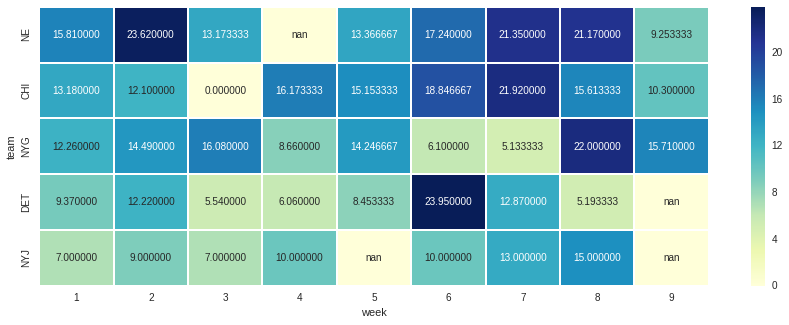

In [11]:
# We can use a Heatmap to analyze teams kicker and qb performance
teams = ['NE', 'CHI', 'NYG', 'DET', 'NYJ']
team_data = qb_k_data[qb_k_data.team.isin(teams)]
team_data = team_data[team_data.week < 10]
ptable = pd.pivot_table(
    team_data, 
    values='fanduel_points', 
    index=["team"], 
    columns='week')
reorder_teams = ptable.reindex(teams)
pylab.figure(figsize=(15,5))
sns.heatmap(reorder_teams, annot=True, fmt="f", cmap="YlGnBu")

# NaN values are bye weeks



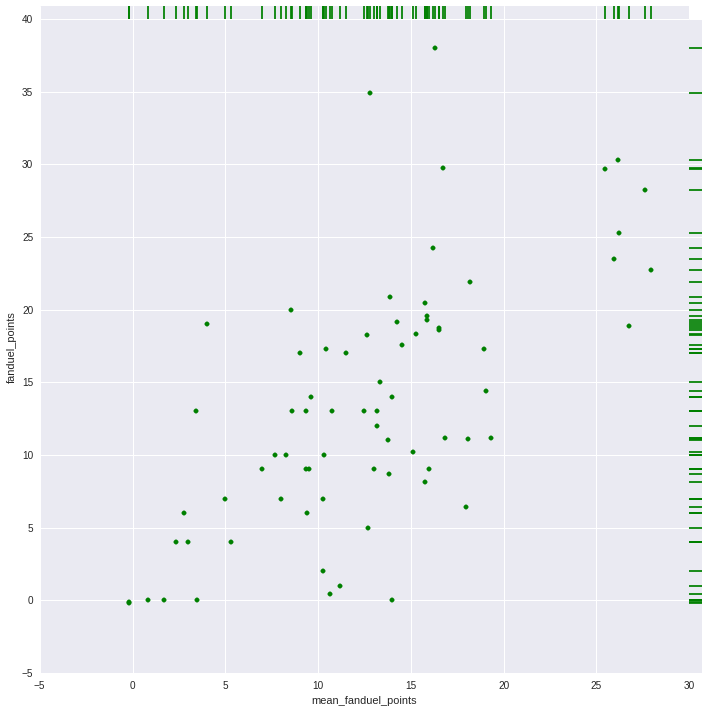

In [12]:
# Are previous week's points a good predictor of current week's points? 
# Let's consider only kicker and QB data for these teams
# We have to exclude week 1 here since there is no previous weeks' mean
team_data_no_week_1 = team_data[team_data.week > 1]
grid = sns.JointGrid(team_data_no_week_1['mean_fanduel_points'], 
              team_data_no_week_1['fanduel_points'],space=0, size=10, ratio=50)
grid.plot_joint(plt.scatter, color="g")
grid.plot_marginals(sns.rugplot, height=1, color="g")

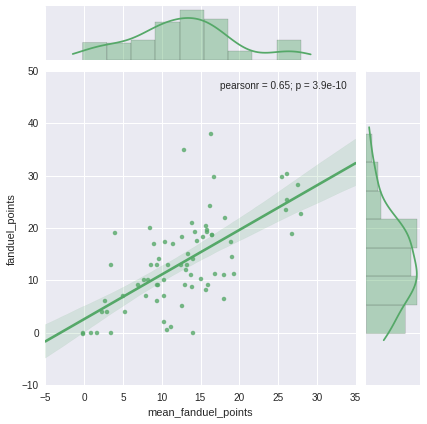

In [13]:
# We can use jointplot (uses JointGrid internally) to get a quick regression line for this
sns.jointplot('mean_fanduel_points', 'fanduel_points', data=team_data_no_week_1, 
              kind="reg", color=sns.color_palette()[1])

In [15]:
# QB's are significantly more important than any other position. Let's dig in
qb_df = raw_df[raw_df.position == 'QB']

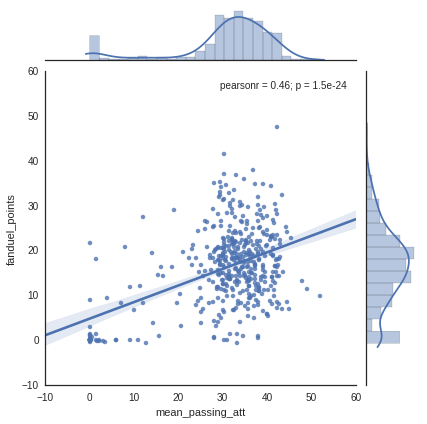

In [41]:
# Passing attempts from previous weeks --- is there a trend with next week's performance? No
sns.jointplot(qb_df['mean_passing_att'], 
              qb_df['fanduel_points'], kind="reg")

In [19]:
import sklearn


In [20]:
# Let's prep for modeling
model_data = top_positions_only[top_positions_only.week > 1]

# Let's cut our target out so we don't train on it
target = model_data.pop('fanduel_points')

# We don't need player id's --- let's throw this away
throw_away = model_data.pop('player_id')

import sklearn.cross_validation

(train_data, 
 test_data, 
 train_target, 
 test_target) = sklearn.cross_validation.train_test_split(
    model_data, target, test_size=0.2, random_state=1337
)

In [21]:
#Handle categorical vars
import sklearn.preprocessing
import sklearn.feature_extraction
from sklearn.feature_extraction import DictVectorizer
encoder = DictVectorizer(sparse=False)

#Let's do one-hot encoding in sklearn using DictVectorizer
categorical_vars = ['full_name', 'position', 'team', 'week', 'opponent', 'home_team', 'away_team']
vardata = train_data[categorical_vars].fillna('MISSING')
encoder.fit(vardata.to_dict(orient='records'))
train_catdata = encoder.transform(vardata.to_dict(orient='records'))

test_vardata = test_data[categorical_vars].fillna('MISSING')
test_catdata = encoder.transform(
    test_vardata[categorical_vars].to_dict(orient='records'))

pd.DataFrame(train_catdata).describe()


,0,1,2,3,4,5,6,7,8,9,...,590,591,592,593,594,595,596,597,598,599
count,3732.000000,3732.000000,3732.000000,3732.000000,3732.000000,3732.000000,3732.000000,3732.000000,3732.000000,3732.000000,...,3732.000000,3732.000000,3732.000000,3732.000000,3732.000000,3732.000000,3732.000000,3732.000000,3732.000000,3732.000000
mean,0.036977,0.032958,0.032422,0.033226,0.029743,0.032958,0.031886,0.028403,0.038585,0.031350,...,0.036977,0.038585,0.028939,0.031083,0.029743,0.030815,0.030815,0.042069,0.035906,9.586013
std,0.188732,0.178551,0.177143,0.179251,0.169900,0.178551,0.175721,0.166144,0.192630,0.174286,...,0.188732,0.192630,0.167657,0.173564,0.169900,0.172838,0.172838,0.200773,0.186080,4.703238
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,10.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,14.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,17.000000


In [22]:
#Handle numeric vars
from sklearn.preprocessing import Imputer
imputer = Imputer(strategy='median')

numeric_vars = list(set(train_data.columns.tolist()) - set(categorical_vars))

numdata = train_data[numeric_vars]
imputer.fit(numdata)

train_numdata = imputer.transform(numdata)
test_numdata = imputer.transform(test_data[numeric_vars])


In [23]:
train_this = np.hstack([train_numdata, train_catdata])
test_this = np.hstack([test_numdata, test_catdata])

In [24]:
import sklearn
from sklearn.linear_model import LinearRegression

lr = LinearRegression(fit_intercept=False)
lr.fit(train_numdata, train_target)

lr_predictions = pd.Series(lr.predict(test_numdata),
                           name='Linear Regression')

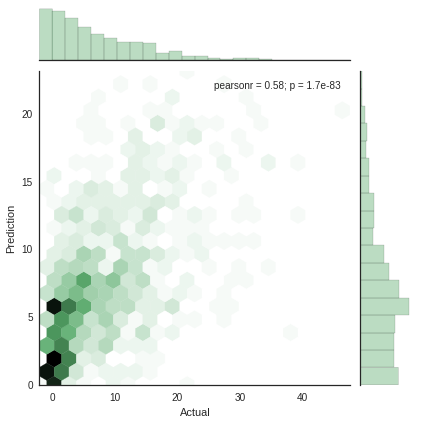

In [25]:

p_df = pd.DataFrame({'Prediction': lr_predictions,
                     'Actual': test_target.values})

pylab.figure(figsize=(10, 10))
sns.jointplot('Actual', 'Prediction', data=p_df, 
              kind="hex", color=sns.color_palette()[1])
#Let's take a look at our residuals using using just the categorical vars

In [26]:
from sklearn import metrics

test_metrics = {
    'Explained Variance': metrics.explained_variance_score,
    'MAE': metrics.mean_absolute_error,
    'MSE': metrics.mean_squared_error,
    'MedAE': metrics.median_absolute_error,
    'R2': metrics.r2_score
}
def metrics_report(*predictions):
    records = []
    for prediction_set in predictions:
        record = {'name': prediction_set.name}
        for metric_name in sorted(test_metrics.keys()):
            metric_func = test_metrics[metric_name]
            record[metric_name] = metric_func(test_target, prediction_set)
        records.append(record)
    frame = pd.DataFrame.from_records(records).set_index('name')
    return frame
        
metrics_report(lr_predictions)

,Explained Variance,MAE,MSE,MedAE,R2
name,,,,,
Linear Regression,0.326886,4.506416,39.608402,3.099153,0.32456


In [27]:

mean_response = np.mean(train_target)
mean_predictions = pd.Series(np.ones_like(test_target) * mean_response,
                             name='Mean Response')

median_response = np.median(train_target)
median_predictions = pd.Series(np.ones_like(test_target) * median_response,
                               name='Median Response')

metrics_report(mean_predictions, 
               median_predictions, 
               lr_predictions)

,Explained Variance,MAE,MSE,MedAE,R2
name,,,,,
Mean Response,0.000000,6.081240,58.682422,5.595247,-0.000708
Median Response,0.000000,5.798071,61.850255,4.600000,-0.054729
Linear Regression,0.326886,4.506416,39.608402,3.099153,0.324560


In [31]:
#Time for ElasticNet

from sklearn.grid_search import GridSearchCV
from sklearn.linear_model import ElasticNet

estimator = ElasticNet()

parameters = {
    'alpha': np.linspace(0.1, 2, 10, endpoint=True),
    'l1_ratio': np.linspace(0, 1, 10, endpoint=True)
}

enet = GridSearchCV(estimator, parameters)
enet.fit(train_numdata, train_target)


/home/brianb/.virtualenvs/odsc/local/lib/python2.7/site-packages/sklearn/linear_model/coordinate_descent.py:432: UserWarning: Coordinate descent with alpha=0 may lead to unexpected results and is discouraged.
  positive)


GridSearchCV(cv=None, error_score='raise',
       estimator=ElasticNet(alpha=1.0, copy_X=True, fit_intercept=True, l1_ratio=0.5,
      max_iter=1000, normalize=False, positive=False, precompute=False,
      random_state=None, selection='cyclic', tol=0.0001, warm_start=False),
       fit_params={}, iid=True, loss_func=None, n_jobs=1,
       param_grid={'alpha': array([ 0.1    ,  0.31111,  0.52222,  0.73333,  0.94444,  1.15556,
        1.36667,  1.57778,  1.78889,  2.     ]), 'l1_ratio': array([ 0.     ,  0.11111,  0.22222,  0.33333,  0.44444,  0.55556,
        0.66667,  0.77778,  0.88889,  1.     ])},
       pre_dispatch='2*n_jobs', refit=True, score_func=None, scoring=None,
       verbose=0)

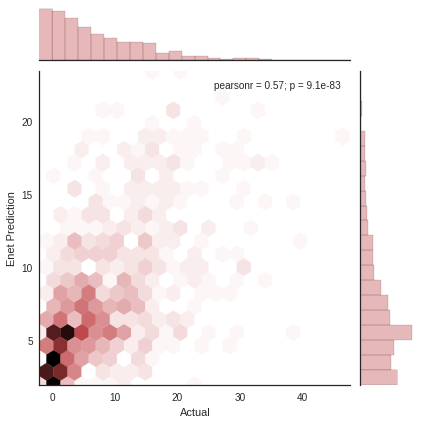

In [33]:
enet_predictions = pd.Series(enet.predict(test_numdata),
                             name='Elastic Net')
p_df = pd.DataFrame({'Enet Prediction': enet_predictions,
                     'Actual': test_target.values})

pylab.figure(figsize=(10, 10))
sns.jointplot('Actual', 'Enet Prediction', data=p_df, kind="hex",
              color=sns.color_palette()[2])

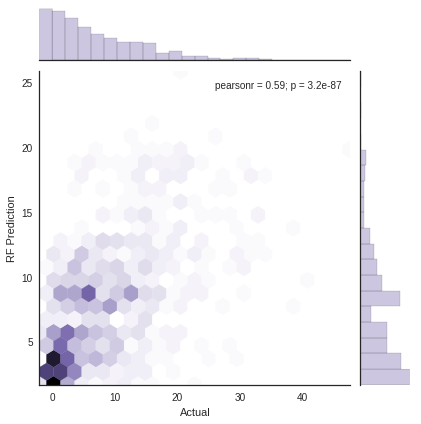

In [34]:
from sklearn.grid_search import GridSearchCV
from sklearn.ensemble import RandomForestRegressor
estimator = RandomForestRegressor()

parameters = {'n_estimators': (5, 10, 15, 20, 25, 30, 35),
              'max_depth': (3, 5, 7, 9, 11),
             }
rfr = GridSearchCV(estimator, parameters, n_jobs=3)
rfr.fit(train_this, train_target)

rfr_predictions = pd.Series(rfr.predict(test_this),
                            name='Random Forest')

p_df = pd.DataFrame({'RF Prediction': rfr_predictions,
                     'Actual': test_target.values})

pylab.figure(figsize=(10, 10))
sns.jointplot('Actual', 'RF Prediction', data=p_df, kind="hex",
              color=sns.color_palette()[3])


In [35]:
metrics_report(mean_predictions,
               median_predictions,
               lr_predictions,
               enet_predictions,
               rfr_predictions)

,Explained Variance,MAE,MSE,MedAE,R2
name,,,,,
Mean Response,0.000000,6.081240,58.682422,5.595247,-0.000708
Median Response,0.000000,5.798071,61.850255,4.600000,-0.054729
Linear Regression,0.326886,4.506416,39.608402,3.099153,0.324560
Elastic Net,0.328991,4.673690,39.350507,3.554817,0.328958
Random Forest,0.343705,4.529366,38.495439,3.350017,0.343539


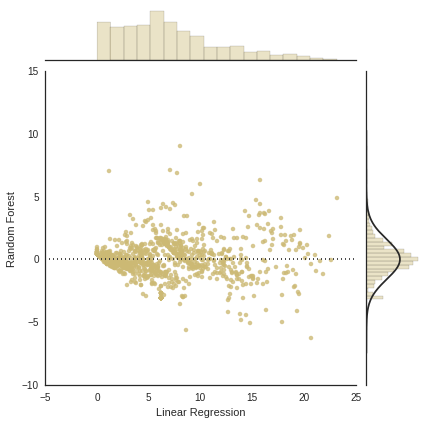

In [36]:

lr_diffs = lr_predictions - test_target
lr_diffs.name = 'LinearRegression Error'
rfr_diffs = rfr_predictions - test_target
rfr_diffs.name = 'RandomForest Error'

sns.jointplot(lr_predictions, rfr_predictions, kind='resid', color=sns.color_palette()[4])

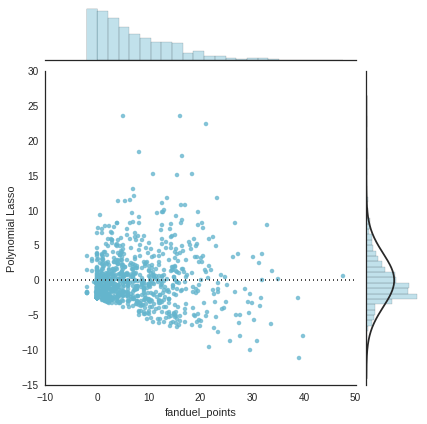

In [45]:

from sklearn.linear_model import Lasso
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline

degree = 2

model = make_pipeline(PolynomialFeatures(degree), Lasso())
model.fit(train_numdata, train_target)

poly_preds = pd.Series(model.predict(test_numdata),
                       name='Polynomial Lasso',
                       index=test_target.index)


sns.jointplot(test_target, 
              poly_preds,
              kind='resid',
              color=sns.color_palette()[5])   

In [46]:
metrics_report(mean_predictions,
               median_predictions,
               lr_predictions,
               enet_predictions,
               rfr_predictions,
               poly_preds)

,Explained Variance,MAE,MSE,MedAE,R2
name,,,,,
Mean Response,0.000000,6.081240,58.682422,5.595247,-0.000708
Median Response,0.000000,5.798071,61.850255,4.600000,-0.054729
Linear Regression,0.326886,4.506416,39.608402,3.099153,0.324560
Elastic Net,0.328991,4.673690,39.350507,3.554817,0.328958
Random Forest,0.343705,4.529366,38.495439,3.350017,0.343539
Polynomial Lasso,0.290755,4.784674,41.591149,3.568572,0.290748
